In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# External dependencies
import os

import cudf  # cuDF is an implementation of Pandas-like Dataframe on GPU
# import rmm

import nvtabular as nvt

from sklearn.model_selection import train_test_split

In [3]:
INPUT_DATA_DIR = os.environ.get(
    "INPUT_DATA_DIR", os.path.expanduser("~/nvt-examples/end-to-end-poc/data/")
)

## Movie Feature Engineering

In [4]:
movie_genres = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "movie_genres.parquet"))
movie_genres.head()

,movieId,genres
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,"[Adventure, Children, Fantasy]"
2,3,"[Comedy, Romance]"
3,4,"[Comedy, Drama, Romance]"
4,5,[Comedy]


In [5]:
movie_tags = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "movie_tags.parquet"))
movie_tags.head()

,movieId,tags_unique,tags_nunique
0,1,"[2009 reissue in Stereoscopic 3-D, 3D, 55 movi...",126
1,2,"[Adaptation of Book, CLV, Children, Chris Van ...",44
2,3,"[Ann Margaret, Burgess Meredith, CLV, Daryl Ha...",23
3,4,"[CLV, based on novel or book, characters, chic...",8
4,5,"[CLV, Comedy, Diane Keaton, Fantasy, Steve Mar...",20


In [6]:
tags_ds = nvt.Dataset(movie_tags)

In [7]:
cat_with_genres = ["tags_unique", "movieId"] >> nvt.ops.JoinExternal(movie_genres, on=["movieId"])

In [8]:
cat_features = cat_with_genres >> nvt.ops.Categorify()

In [9]:
cont_features = nvt.ColumnGroup([])
other_features = nvt.ColumnGroup(["tags_nunique"])

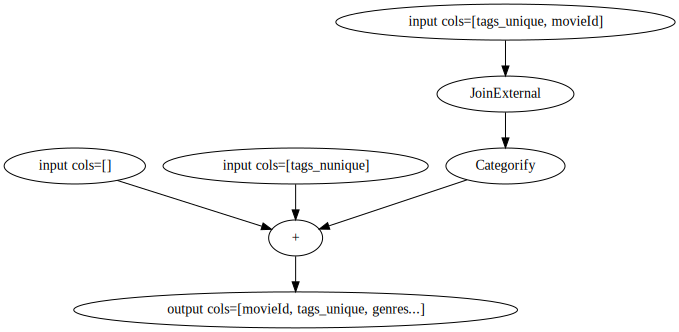

In [10]:
output = cat_features + cont_features + other_features
(output).graph

In [11]:
workflow = nvt.Workflow(output)

In [12]:
%%time
workflow.fit(tags_ds)

CPU times: user 390 ms, sys: 24.5 ms, total: 415 ms
Wall time: 426 ms


In [13]:
%time
movie_features = workflow.transform(tags_ds)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.68 µs


In [14]:
movie_features.to_ddf().compute().to_parquet(os.path.join(INPUT_DATA_DIR, "movie_features.parquet"))

In [15]:
workflow.save(os.path.join(INPUT_DATA_DIR, "movie_features_workflow"))